In [1]:
data_salvar_modelo = '220525_datasets'

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random
#!pip3 install pickle5
#import pickle5 as pickle
import pickle
import glob

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#!pip install imblearn
from  imblearn.under_sampling  import  CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
# https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

#!pip install xgboost==0.90
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
# ler dataset
data = pd.read_excel('4647_dataset_clorofila_classif_iqar.xlsx')
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Dominio']]
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Dominio
0,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,Estados_Unidos
1,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,Estados_Unidos
2,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,Estados_Unidos
3,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,Estados_Unidos
4,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,Estados_Unidos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,3519.0,3306,3438,3500,3906,4193,4319.0,3967,4355.0,5608.0,4225,3913,Europa
4360,4195.0,4845,4470,4030,4431,4510,4495.0,4926,4548.0,6548.0,4599,3952,ANA
4361,4210.0,5399,4967,4527,4781,4357,4109.0,5068,3952.0,6951.0,4815,4130,ANA
4363,4011.0,3698,3711,3699,4144,4748,4895.0,5163,4981.0,7035.0,4811,4178,Europa


In [4]:
# contar classes
print('Quantidade por classe:')
print(df['Dominio'].value_counts())

# filtrar por classe
df_0 = df[df['Dominio']=='Estados_Unidos']
df_1 = df[df['Dominio']=='Europa']
df_2 = df[df['Dominio']=='PMQs']
df_3 = df[df['Dominio']=='Campo_Geo']
df_4 = df[df['Dominio']=='Campo_Limnologia']
df_5 = df[df['Dominio']=='GemStat']
df_6 = df[df['Dominio']=='ANA']
df_7 = df[df['Dominio']=='Cetesb']
df_8 = df[df['Dominio']=='C6da']

Quantidade por classe:
Estados_Unidos      1830
Europa               558
PMQs                 494
ANA                  175
Campo_Geo            125
Campo_Limnologia      89
GemStat               44
Canada                36
Cetesb                36
Name: Dominio, dtype: int64


In [27]:
# peguei 3 datasets que tinha mais amostras

#separar treino e teste
qtd_amostras_treino = 450

randomlist = random.sample(range(0, df_0.shape[0]), qtd_amostras_treino)
df_0_train = df_0.iloc[randomlist]
df_0_test = df_0.drop(df_0.index[randomlist])

randomlist = random.sample(range(0, df_1.shape[0]), qtd_amostras_treino)
df_1_train = df_1.iloc[randomlist]
df_1_test = df_1.drop(df_1.index[randomlist])

randomlist = random.sample(range(0, df_2.shape[0]), qtd_amostras_treino)
df_2_train = df_2.iloc[randomlist]
df_2_test = df_2.drop(df_2.index[randomlist])

#randomlist = random.sample(range(0, df_6.shape[0]), qtd_amostras_treino)
#df_6_train = df_6.iloc[randomlist]
#df_6_test = df_6.drop(df_6.index[randomlist])

print('Classe 0 - treino:', df_0_train.shape[0], '/ teste:', df_0_test.shape[0])
print('Classe 1 - treino:', df_1_train.shape[0], '/ teste:', df_1_test.shape[0])
print('Classe 2 - treino:', df_2_train.shape[0], '/ teste:', df_2_test.shape[0])
#print('Classe 6 - treino:', df_6_train.shape[0], '/ teste:', df_6_test.shape[0])

Classe 0 - treino: 450 / teste: 1380
Classe 1 - treino: 450 / teste: 108
Classe 2 - treino: 450 / teste: 44


In [28]:
# concatenar dataframes
frames_train = [df_0_train, df_1_train, df_2_train]#, df_6_train]
df_train = pd.concat(frames_train)
frames_test = [df_0_test, df_1_test, df_2_test]#, df_6_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (1350, 12) / rotulos: (1350,)
Tamanho test: (1532, 12) / rotulos: (1532,)


In [40]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

In [41]:
norm_X_train = X_train
norm_X_test = X_test

In [43]:
norm_X_test

array([[3.100e+01, 5.100e+01, 1.600e+01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [3.100e+01, 5.100e+01, 1.600e+01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [3.100e+01, 5.100e+01, 1.600e+01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.304e+03, 1.193e+03, 1.370e+03, ..., 2.051e+03, 1.439e+03,
        1.300e+03],
       [1.304e+03, 1.193e+03, 1.370e+03, ..., 2.051e+03, 1.439e+03,
        1.300e+03],
       [1.304e+03, 1.193e+03, 1.370e+03, ..., 2.051e+03, 1.439e+03,
        1.300e+03]])

# Naive Bayes

Melhores hiperparametros do modelo: {'var_smoothing': 0.001}

Acuracia:  0.7813315926892951
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1380
           1       0.07      0.09      0.08       108
           2       0.00      0.00      0.00        44

    accuracy                           0.78      1532
   macro avg       0.33      0.32      0.32      1532
weighted avg       0.82      0.78      0.80      1532



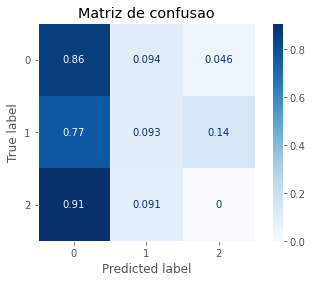

In [15]:
#treinar naive bayes

# pesquisa em grade
param_grid_nb = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

grid_nb = GridSearchCV(GaussianNB(),param_grid_nb,refit=True)
grid_nb.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_nb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_nb, open(data_salvar_modelo+'_nb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_nb_predictions = grid_nb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_nb_predictions))
#print(confusion_matrix(y_teste,grid_nb_predictions))
print(classification_report(y_test, grid_nb_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_nb, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# SVM

Melhores hiperparametros do modelo: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Acuracia:  0.6990861618798956
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1380
           1       0.17      0.68      0.27       108
           2       0.34      0.91      0.50        44

    accuracy                           0.70      1532
   macro avg       0.49      0.76      0.53      1532
weighted avg       0.89      0.70      0.76      1532



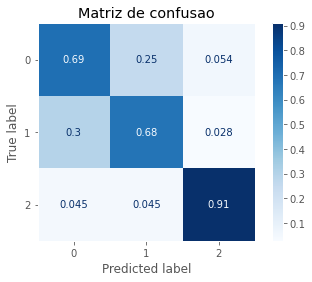

In [18]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'C': [0.1,1, 10, 100,1000], 
                  'gamma': [1,0.1,0.01,0.001,0.0001], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

grid_svm = GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_svm, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_svm, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# Random Forest

Melhores hiperparametros do modelo: {'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Acuracia:  0.7656657963446475
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1380
           1       0.23      0.74      0.35       108
           2       0.37      0.98      0.54        44

    accuracy                           0.77      1532
   macro avg       0.53      0.83      0.58      1532
weighted avg       0.91      0.77      0.81      1532



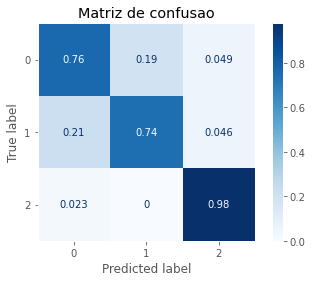

In [19]:
#treinar random forest

# pesquisa em grade
param_grid_rf = {'bootstrap': [True, False], 
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 2, 4], 
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf,refit=True, n_jobs=-1)
grid_rf.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_rf.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_rf, open(data_salvar_modelo+'_rf.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_rf_predictions = grid_rf.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_rf_predictions))
#print(confusion_matrix(y_teste,grid_rf_predictions))
print(classification_report(y_test, grid_rf_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_rf, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# XGBoost

In [21]:
#treinar xgboost

# pesquisa em grade
param_grid_xgb = { 'min_child_weight': [1, 5, 10], 
                  'gamma': [0.5, 1, 1.5, 2, 5], 
                  'subsample': [0.6, 0.8, 1.0], 
                  'colsample_bytree': [0.6, 0.8, 1.0], 
                  'n_estimators': [400, 500, 600, 700], 
                  'learning_rate': [0.1, 0.01, 0.001],
                  'max_depth': [3, 4, 5] }

grid_xgb = GridSearchCV(XGBClassifier(objective='binary:logistic', 
                                      silent=True, nthread=-1, verbosity = 0, 
                                      use_label_encoder=False, n_jobs=-1),
                        param_grid_xgb, refit=True, verbose=True)

#le = LabelEncoder()
#y_train = le.fit_transform(y_train)

grid_xgb.fit(norm_X_train,y_train.astype(int))

print('Melhores hiperparametros do modelo:', grid_xgb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_xgb, open(data_salvar_modelo+'_xgb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_xgb_predictions = grid_xgb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test.astype(int), grid_xgb_predictions))
#print(confusion_matrix(y_teste,grid_xgb_predictions))
print(classification_report(y_test.astype(int), grid_xgb_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_xgb, norm_X_test, y_test.astype(int), cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
Melhores hiperparametros do modelo: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6}

Acuracia:  0.7545691906005222
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1380
           1       0.21      0.71      0.32       108
           2       0.42      0.98      0.59        44

    accuracy                           0.75      1532
   macro avg       0.53      0.81      0.59      1532
weighted avg       0.91      0.75      0.80      1532



NameError: name 'norm_X_teste' is not defined

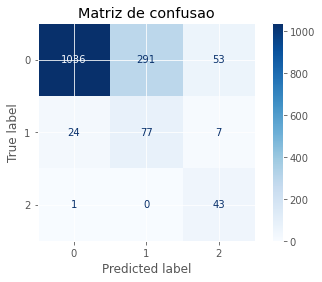

In [22]:
# matrix de confusao
matrix = plot_confusion_matrix(grid_xgb, norm_X_test, y_test.astype(int), cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

In [ ]:
# MLP Grid Search

In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
mlp = MLPClassifier(max_iter = 100)

In [33]:
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [34]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)

In [35]:
clf.fit(norm_X_train, y_train) 

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [36]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [37]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.530 (+/-0.060) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.542 (+/-0.093) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.485 (+/-0.109) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.599 (+/-0.078) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.531 (+/-0.072) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.581 (+/-0.038) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
0.549 (+/-0.046) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.563 (+/-0.097) 

In [39]:
y_true, y_pred = y_test , clf.predict(norm_X_test)
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      1380
           1       0.13      0.68      0.22       108
           2       0.12      0.57      0.19        44

    accuracy                           0.52      1532
   macro avg       0.40      0.58      0.36      1532
weighted avg       0.86      0.52      0.62      1532



In [ ]:
print(clf.)